---
fig-cap-location: margin
code-fold: false
---
# Classifying Palmer Penguins

![Image source: \@gabednick](https://www.gabemednick.com/post/penguin/featured.png)

## Abstract

In this blog post, I take the Palmer Penguins dataset and try to determine the best features to be used to determine the species of a penguin based on its measurements. Firstly, I create two figures and a table to analysize the relationships between features. Then I use sci-kit learns feature selection with chi-squared tests to pick 2 numerical features and 1 categorical feature. Then using those features, I train and test a logistic regression model. The model was fairly accurate but to understand the results better, I plot the decision regions and use a confusion matrix. 

In [18]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [19]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


## Data Preparation

This is code from Professor Phil's website. It removes the columns that we don't use and NA values, converts the categorical feature columns into "one-hot encoded" 0-1 columns and saves the dataframe X_train. Also, "Species" is coded with the LabelEncoder and is saved as y_train.

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

We can check what the columns look like now.

In [21]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


## Data Visualization

### Figures

I created two graphs each 2 quantative columns and 1 qualitative columns. Plot 1 shows the relationship with the body mass and flipper length between different penguin species. Plot 2 shows the difference in Culmen Length and depth across different penguin species.


In [22]:
# Get the unencoded columns for easier graphing.
qual = train[["Island", "Sex", "Species"]].dropna()

# Shorten species label for the legend
qual["Species"] = qual["Species"].apply(lambda x: "Chinstrap" if x == "Chinstrap penguin (Pygoscelis antarctica)" 
                                         else ("Gentoo" if x == "Gentoo penguin (Pygoscelis papua)" 
                                               else "Adelie"))

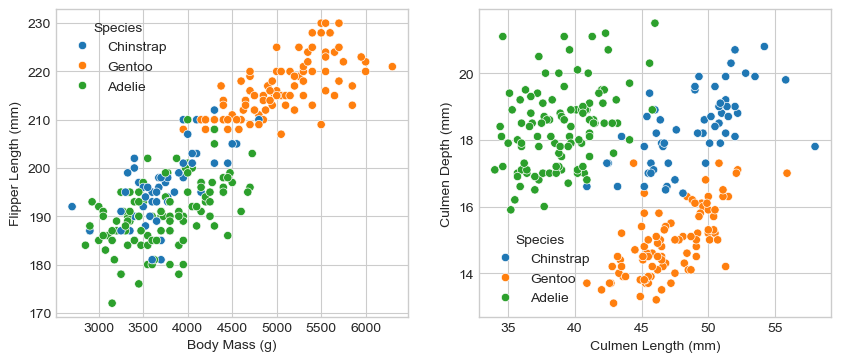

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
   
p1 = sns.scatterplot(X_train, x = "Body Mass (g)", y = "Flipper Length (mm)", hue=qual["Species"], ax = ax[0])
p2 = sns.scatterplot(X_train, x = "Culmen Length (mm)", y = "Culmen Depth (mm)", hue=qual["Species"], ax = ax[1])


Left side: Plot 1. The Gentoo penguins tend to be the biggest while Chinstrap and Adelie seem to have a great overlap in size. The Adelie seem to have slightly more variety in mass given a flipper length compared to Chinstrap. This is features seem decent for selection because there is some correlation between species and body size but they are not easily distinguishable by species.

Right side: Plot 2. Based on the graph, the each specie of penguin seemed to have distinct beaks. The Adelie have greatest culmen depth but shortest length. The Gentoo have longer culmens but not as much depth and the Chinstrap lie in the middle with medium to large culmens. These are good features because there is a clear distinction in culmen sizes between species of penquins.

### Table
Now I create a summary table of the penguins measurements based on clutch completetion. 

In [24]:
table = X_train[["Clutch Completion_Yes", "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]]
table.groupby("Clutch Completion_Yes").aggregate(['min', 'median', 'max'])

Culmen Length (mm)              Culmen Depth (mm)  \
                                     min median   max               min   
Clutch Completion_Yes                                                     
False                               35.9  43.35  58.0              13.7   
True                                34.0  45.10  55.9              13.1   

                                   Flipper Length (mm)                \
                      median   max                 min median    max   
Clutch Completion_Yes                                                  
False                  17.85  19.9               172.0  195.0  225.0   
True                   17.20  21.5               176.0  198.0  230.0   

                      Body Mass (g)                  
                                min  median     max  
Clutch Completion_Yes                                
False                        2700.0  3737.5  5700.0  
True                         2850.0  4100.0  6300.0

Table 1: This table shows the biggest difference between penguins that had a full clutch and those that did not was the weight. Most of the penguins the produced two eggs weighed about 300 grams more. There is most likely not a causation but there a may be a correlation. Since clutch completion does not seem impact this data very much, it may not be a feature worth looking at.

## Feature selection 

Here I use sci-kits SelectKBest to pick the 3 feautures I'm going to use for my model. I had to seperate feature selection because all 3 selected features would be numerical. SelectKBest selects the k best features based on user specified scoring function. I used chi-squared since my feautres were meant for classification and they were non-negative.  

In [25]:
from sklearn.feature_selection import SelectKBest, chi2

# Selecting 2 numerical feature
quant = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']
sel1 = SelectKBest(chi2, k=2)
sel1.fit_transform(X_train[quant], y_train)
f1 = sel1.get_feature_names_out()

# Selecting 1 categorical feature
qual = ["Clutch Completion_Yes", "Clutch Completion_No", "Island_Biscoe", "Island_Dream", "Island_Torgersen", "Sex_FEMALE", "Sex_MALE"]
sel2 = SelectKBest(chi2, k=1)
sel2.fit_transform(X_train[qual], y_train)
f2 = sel2.get_feature_names_out()


This function is so that I can get all the variations of the categorical feature.

In [26]:
def get_feat(f1, cat):
    cols = list(f1)
    clutch = ["Clutch Completion_Yes", "Clutch Completion_No"]
    island = ["Island_Biscoe", "Island_Dream", "Island_Torgersen"]
    sex = ["Sex_FEMALE", "Sex_MALE"]
    
    if cat in clutch: return cols + clutch
    if cat in island: return cols + island
    if cat in sex: return cols + sex

In [27]:
cols = get_feat(f1, f2[0])
cols

['Flipper Length (mm)',
 'Body Mass (g)',
 'Island_Biscoe',
 'Island_Dream',
 'Island_Torgersen']

So despite the culmen sizes being appearing to be better features, based on the statistical tests the flipper length and body mass were better features. 

## Training

The model is trained on the data with features determined from above. I had to use StandardScalar to avoid a convergence error. I used the Logistic Regression model as it is a good fit for classification. 

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train[cols], y_train)
pipe.score(X_train[cols], y_train)


0.8984375

## Testing

In [29]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
pipe.score(X_test[cols], y_test)

0.8970588235294118

## Results

### Plotting Decision Regions 

Most of this code is adapted from Prof. Phil's website.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (8, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Regions for training set:

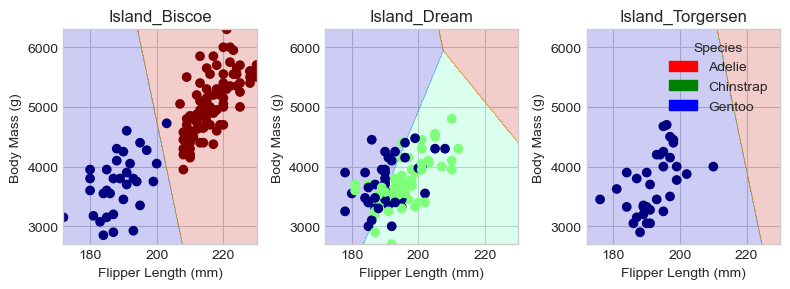

In [32]:
plot_regions(pipe, X_train[cols], y_train)

Regions for testing set:

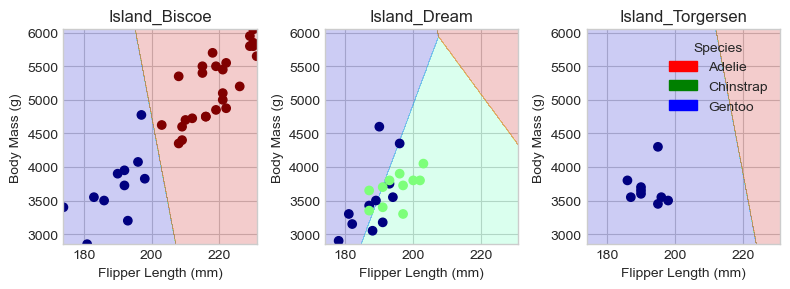

In [33]:
plot_regions(pipe, X_test[cols], y_test)

Looking at these decision plots, we see that our model is pretty successful determing of the difference between Gentoo and Adelie on the Biscoe and Torgersen islands. However, on the Dream island, there is a mixture of Gentoo and Chinstrap where the model the struggles to distinguish between the two. 

### Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix

y_test_pred = pipe.predict(X_test[cols])
confusion_matrix(y_test, y_test_pred)


array([[26,  5,  0],
       [ 2,  9,  0],
       [ 0,  0, 26]])

Once again, this shows that model struggled the most with Gentoo and Chinstrap. 

## Discussion

The model had very similar training and testing accuracy of 0.89. This means the model is fairly solid at predicting penguins based on the flipper lenth, body mass and island. Based on the decision regions, the model struggled to correctly determine the difference between Chinstrap and Gentoo on the Island Dream. It seems that those 2 species are of similar sizes and therefore are hard to differentiate. 

During this blog post, the two biggest things were I learned about different tools for feature selection and the need to normalize data before putting it in a model. In terms of feature selection, sci-kit learn provides various methods whether variance, statistical tests or recursion. I went with statistical test as it seemed more thorough then determining a random variance yet not as complex as the recursion. For normalizing data, I learned how to deal with a convergence error when trainig a model. Through some investigation I came to understand I recieved that error  because some of the features may not normally distributed. I used sci-kit recommended scaling function to standardize the data and everything was fine after that. Finally, I got more practice with modifing and selecting data from dataframes in general.